<a href="https://colab.research.google.com/github/Undasnr/DL-ML/blob/main/Ronny_Seq2Seq_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1. Execution of machine translation and code reading**

In [2]:
import numpy as np
import keras
import os
from pathlib import Path

fpath = keras.utils.get_file(origin=None, fname="fra-eng.zip", extract=False) if False else None  # Placeholder, will skip
dirpath = Path('.').absolute()
os.system(f"wget -q -O {dirpath}/fra-eng.zip http://www.manythings.org/anki/fra-eng.zip")  # UPDATED
os.system(f"unzip -q {dirpath}/fra-eng.zip -d {dirpath}")

batch_size = 64
epochs = 100
latent_dim = 256
num_samples = 10000
data_path = os.path.join(dirpath, "fra.txt")

input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, "r", encoding="utf-8") as f:
    lines = f.read().split("\n")
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split("\t")
    target_text = "\t" + target_text + "\n"
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype="float32",
)
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype="float32",
)
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype="float32",
)

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
    encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0
    for t, char in enumerate(target_text):
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
    decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0
    decoder_target_data[i, t:, target_token_index[" "]] = 1.0

encoder_inputs = keras.Input(shape=(None, num_encoder_tokens))
encoder = keras.layers.LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]

decoder_inputs = keras.Input(shape=(None, num_decoder_tokens))
decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])
model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
)
model.save("s2s_model.keras")

model = keras.models.load_model("s2s_model.keras")

encoder_inputs = model.input[0]
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output
encoder_states = [state_h_enc, state_c_enc]
encoder_model = keras.Model(encoder_inputs, encoder_states)

decoder_inputs = model.input[1]
decoder_state_input_h = keras.Input(shape=(latent_dim,))
decoder_state_input_c = keras.Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[3]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)

reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq, verbose=0)
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    target_seq[0, 0, target_token_index["\t"]] = 1.0
    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value, verbose=0
        )
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char
        if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0
        states_value = [h, c]
    return decoded_sentence

for seq_index in range(20):
    input_seq = encoder_input_data[seq_index : seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print("-")
    print("Input sentence:", input_texts[seq_index])
    print("Decoded sentence:", decoded_sentence)

Number of samples: 10000
Number of unique input tokens: 70
Number of unique output tokens: 91
Max sequence length for inputs: 14
Max sequence length for outputs: 59
Epoch 1/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.7078 - loss: 1.5303 - val_accuracy: 0.7176 - val_loss: 1.0927
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7453 - loss: 0.9628 - val_accuracy: 0.7264 - val_loss: 0.9672
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7631 - loss: 0.8620 - val_accuracy: 0.7449 - val_loss: 0.8805
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7840 - loss: 0.7792 - val_accuracy: 0.7756 - val_loss: 0.7856
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8034 - loss: 0.6879 - val_accuracy: 0.7844 - val_loss: 0.7268
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8139 - loss: 0.6428 - val_accuracy: 0.7975 - val_loss: 0.6977
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step -

**Summary of lstm_seq2seq.py:**

Lines 1-22: Module Docstring and License

>This is a comment block explaining the script's purpose: "Character-level recurrent sequence-to-sequence model" and its license (MIT).

Lines 24-31: Import Libraries

>Imports necessary modules from Keras (Model, LSTM, Dense, Input, etc.) and NumPy. These provide the building blocks for the neural network and data handling.

Lines 34-39: Hyperparameter Settings

>Defines key constants for the experiment:

>batch_size = 64: Number of samples per gradient update.

>epochs = 100: Number of times to iterate over the entire training dataset.

>latent_dim = 256: The dimensionality of the hidden state of the LSTM layers (the size of the model's "memory").

>num_samples = 10000: The number of sentence pairs to train on. Limits the data for a quicker demo.

Lines 42-51: Data Loading

>Reads the text file fra.txt which contains English-French sentence pairs.

>It splits each line into an English and French sentence.

>It takes only the first num_samples pairs to keep the training time short.

Lines 54-75: Character-based Tokenization (Vectorization)

>This is the Characterized tokenization you mentioned.

>It doesn't use words like "cat" but treats each character (c, a, t, ' ', '!') as a token.

Lines 58-63: It creates sets of all unique characters found in the input texts (English) and target texts (French). It then sorts them to create a fixed vocabulary.

Lines 66-67: Calculates the maximum length of input and output sentences. This is needed to pad sequences to a uniform length.

Lines 70-75: Creates dictionaries that map each character to a unique integer index (input_token_index, target_token_index). This is how text is converted into numbers the model can understand.

Lines 78-95: Data Vectorization (Creating the Model's Inputs)

Lines 81-87: Encoder Input: Creates a 3D array of shape (num_samples, max_encoder_seq_length, num_encoder_tokens). This is a one-hot encoded representation of the English sentences. For each sentence, for each character position, there is a vector the size of the English vocabulary, with a 1 indicating the presence of that character.

Lines 90-95: Decoder Input & Target Data: Creates two arrays for the French sentences.

>decoder_input_data is the French sentence, but shifted by one. It starts with a \t (tab character, the start-of-sequence token).

>decoder_target_data is the French sentence, but ends with a \n (newline character, the end-of-sequence token). The model is trained to predict this sequence.

Lines 98-133: Building the Seq2Seq Model

>This defines the neural network architecture using the Functional API.

Lines 101-108: Encoder: An input layer is defined, followed by an LSTM layer. The LSTM returns its internal state (state_h, state_c) in addition to its output. For the encoder, we discard the output and only keep the states, which encapsulate the "meaning" of the input sentence.

Lines 111-119: Decoder Setup: The decoder is another LSTM layer. Its initial state is set to be the final state from the encoder. This is the crucial link that passes the information from the input to the output.

Lines 122-126: Decoder Output: The output from the decoder LSTM is passed through a Dense (fully connected) layer with a softmax activation. This layer predicts the probability of the next character in the French sentence, given the previous characters and the encoder states.

Line 129: Define the Model: The Keras Model is created by specifying its inputs (the encoder input and decoder input) and its output (the decoder's predictions).

Lines 136-138: Model Compilation

>Configures the model for training. It uses the RMSprop optimizer and the categorical_crossentropy loss function, which is standard for multi-class classification problems (like predicting the next character out of many possibilities).

Line 141: Model Training (model.fit)

>This is the command that trains the model. It uses the encoder input, decoder input, and decoder target data we created earlier. It splits off 20% of the data for validation (validation_split=0.2).

Lines 144-183: Inference Mode (Sampling/Translation)

>This section sets up the model to make actual translations after training.

>It defines new models (encoder_model and decoder_model) that are tailored for the step-by-step process of decoding.

Lines 177-183: The Decoding Loop: This is the core inference logic:

>Encode the input sentence into a state vector.

>Start with a target sequence of just the start-of-sequence token (\t).

>Run the decoder for one time step, getting the next character prediction and new states.

>Sample a character from the predictions (e.g., pick the most likely one).

>Append the sampled character to the target sequence.

>Repeat until the end-of-sequence token is generated or the maximum length is reached.

Lines 186-192: Testing the Model

>After training, the code runs a test. It picks a few random sentences from the validation set, encodes them, runs them through the inference model (decoding loop), and prints both the original and the decoded sentence, showing you the model's translation.

**2. Image Captioning Inference**

In [5]:
# Clone the repository (let's use a fresh approach)
!rm -rf /content/pytorch-tutorial  # Clean up if any partial clone exists
!git clone https://github.com/yunjey/pytorch-tutorial.git

Cloning into 'pytorch-tutorial'...
remote: Enumerating objects: 917, done.
remote: Total 917 (delta 0), reused 0 (delta 0), pack-reused 917 (from 1)
Receiving objects: 100% (917/917), 12.80 MiB | 17.46 MiB/s, done.
Resolving deltas: 100% (490/490), done.


In [6]:
# Verify the clone was successful
!ls -la /content/

total 20
drwxr-xr-x 1 root root 4096 Aug 30 09:42 .
drwxr-xr-x 1 root root 4096 Aug 30 09:35 ..
drwxr-xr-x 4 root root 4096 Aug 28 13:42 .config
drwxr-xr-x 5 root root 4096 Aug 30 09:42 pytorch-tutorial
drwxr-xr-x 1 root root 4096 Aug 28 13:43 sample_data


In [7]:
# 3. Explore the structure of the cloned repository
!ls -la /content/pytorch-tutorial/

total 32
drwxr-xr-x 5 root root 4096 Aug 30 09:42 .
drwxr-xr-x 1 root root 4096 Aug 30 09:42 ..
drwxr-xr-x 8 root root 4096 Aug 30 09:42 .git
-rw-r--r-- 1 root root   38 Aug 30 09:42 .gitignore
-rw-r--r-- 1 root root 1057 Aug 30 09:42 LICENSE
drwxr-xr-x 2 root root 4096 Aug 30 09:42 logo
-rw-r--r-- 1 root root 2913 Aug 30 09:42 README.md
drwxr-xr-x 6 root root 4096 Aug 30 09:42 tutorials


In [8]:
# 4. Look for the image captioning project specifically
!find /content/pytorch-tutorial -name "*caption*" -type d

/content/pytorch-tutorial/tutorials/03-advanced/image_captioning


In [9]:
# 5. Check the tutorials directory structure
!ls -la /content/pytorch-tutorial/tutorials/

total 24
drwxr-xr-x 6 root root 4096 Aug 30 09:42 .
drwxr-xr-x 5 root root 4096 Aug 30 09:42 ..
drwxr-xr-x 6 root root 4096 Aug 30 09:42 01-basics
drwxr-xr-x 7 root root 4096 Aug 30 09:42 02-intermediate
drwxr-xr-x 6 root root 4096 Aug 30 09:42 03-advanced
drwxr-xr-x 3 root root 4096 Aug 30 09:42 04-utils


In [10]:
# Navigate to the image captioning directory
try:
    os.chdir('/content/pytorch-tutorial/tutorials/03-advanced/image_captioning')
    print("Success! Current directory:", os.getcwd())
    !ls -la  # Show contents of this directory
except FileNotFoundError:
    print("Path not found. Let's check what's actually in the tutorials directory:")
    !ls -la /content/pytorch-tutorial/tutorials/

Success! Current directory: /content/pytorch-tutorial/tutorials/03-advanced/image_captioning
total 52
drwxr-xr-x 3 root root 4096 Aug 30 09:42 .
drwxr-xr-x 6 root root 4096 Aug 30 09:42 ..
-rw-r--r-- 1 root root 2459 Aug 30 09:42 build_vocab.py
-rw-r--r-- 1 root root 3929 Aug 30 09:42 data_loader.py
-rwxr-xr-x 1 root root  449 Aug 30 09:42 download.sh
-rw-r--r-- 1 root root 2718 Aug 30 09:42 model.py
drwxr-xr-x 2 root root 4096 Aug 30 09:42 png
-rw-r--r-- 1 root root 3113 Aug 30 09:42 README.md
-rw-r--r-- 1 root root   37 Aug 30 09:42 requirements.txt
-rw-r--r-- 1 root root 1553 Aug 30 09:42 resize.py
-rw-r--r-- 1 root root 3033 Aug 30 09:42 sample.py
-rw-r--r-- 1 root root 4498 Aug 30 09:42 train.py


In [11]:
# Examine the README file for instructions
with open('README.md', 'r') as f:
    print(f.read())

# Image Captioning
The goal of image captioning is to convert a given input image into a natural language description. The encoder-decoder framework is widely used for this task. The image encoder is a convolutional neural network (CNN). In this tutorial, we used [resnet-152](https://arxiv.org/abs/1512.03385) model pretrained on the [ILSVRC-2012-CLS](http://www.image-net.org/challenges/LSVRC/2012/) image classification dataset. The decoder is a long short-term memory (LSTM) network. 

![alt text](png/model.png)

#### Training phase
For the encoder part, the pretrained CNN extracts the feature vector from a given input image. The feature vector is linearly transformed to have the same dimension as the input dimension of the LSTM network. For the decoder part, source and target texts are predefined. For example, if the image description is **"Giraffes standing next to each other"**, the source sequence is a list containing **['\<start\>', 'Giraffes', 'standing', 'next', 'to', 'each', 'ot

In [12]:
# Check the download.sh script to see what it does
with open('download.sh', 'r') as f:
    print(f.read())

mkdir data
wget http://msvocds.blob.core.windows.net/annotations-1-0-3/captions_train-val2014.zip -P ./data/
wget http://images.cocodataset.org/zips/train2014.zip -P ./data/
wget http://images.cocodataset.org/zips/val2014.zip -P ./data/

unzip ./data/captions_train-val2014.zip -d ./data/
rm ./data/captions_train-val2014.zip
unzip ./data/train2014.zip -d ./data/
rm ./data/train2014.zip 
unzip ./data/val2014.zip -d ./data/ 
rm ./data/val2014.zip 



In [13]:
# Check the requirements to see what we need to install
with open('requirements.txt', 'r') as f:
    print(f.read())

matplotlib
nltk
numpy
Pillow
argparse


In [14]:
# Look at sample.py to understand how it loads the model
# This will show us the default filenames the code expects
with open('sample.py', 'r') as f:
    sample_code = f.read()
    print("=== sample.py ===")
    print(sample_code)

=== sample.py ===
import torch
import matplotlib.pyplot as plt
import numpy as np 
import argparse
import pickle 
import os
from torchvision import transforms 
from build_vocab import Vocabulary
from model import EncoderCNN, DecoderRNN
from PIL import Image


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_image(image_path, transform=None):
    image = Image.open(image_path).convert('RGB')
    image = image.resize([224, 224], Image.LANCZOS)
    
    if transform is not None:
        image = transform(image).unsqueeze(0)
    
    return image

def main(args):
    # Image preprocessing
    transform = transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.485, 0.456, 0.406), 
                             (0.229, 0.224, 0.225))])
    
    # Load vocabulary wrapper
    with open(args.vocab_path, 'rb') as f:
        vocab = pickle.load(f)

    # Build models
    encoder = EncoderCNN(args.embed_size).eval() 

In [15]:
# Check the model architecture to understand the parameters
with open('model.py', 'r') as f:
    model_code = f.read()
    # Look for class definitions
    lines = model_code.split('\n')
    for i, line in enumerate(lines):
        if 'class ' in line and ('Encoder' in line or 'Decoder' in line):
            print(f"Line {i}: {line}")

Line 6: class EncoderCNN(nn.Module):
Line 25: class DecoderRNN(nn.Module):


In [16]:
# Install required packages first
!pip install -r requirements.txt

In [1]:
# Create necessary directories
import os
os.makedirs('./models', exist_ok=True)
os.makedirs('./data', exist_ok=True)

In [2]:
# Download the pre-trained model
!wget https://www.dropbox.com/s/ne0ixz5d58ccbbz/pretrained_model.zip?dl=0 -O pretrained_model.zip

--2025-08-30 10:00:57--  https://www.dropbox.com/s/ne0ixz5d58ccbbz/pretrained_model.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.66.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.66.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/5pbpnmdqarpl3im03e6sk/pretrained_model.zip?rlkey=t60qk1iyys5fejbbwgvx5p5hq&dl=0 [following]
--2025-08-30 10:00:58--  https://www.dropbox.com/scl/fi/5pbpnmdqarpl3im03e6sk/pretrained_model.zip?rlkey=t60qk1iyys5fejbbwgvx5p5hq&dl=0
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc4a915cd6a6d77186a9b79e6546.dl.dropboxusercontent.com/cd/0/inline/CwbBn88mf4KOAA9RMsbw-BekdEoBP_TedqBV-AVbwtg8nnvaZoOdMJDSaCyIo1Ets4lH41FB2vQlGnkQS872YdK3GiJH7Cu3hj1QQehb5G07MmynuNKfJAU4Fg_g-pZ-bs0vOrae1iKknP672icIEdhH/file# [following]
--2025-08-30 10:00:58--  https://uc4a915cd6a6d77186a9b79e654

In [3]:
# Download the vocabulary file
!wget https://www.dropbox.com/s/26adb7y9m98uisa/vocap.zip?dl=0 -O vocab.zip

--2025-08-30 10:01:27--  https://www.dropbox.com/s/26adb7y9m98uisa/vocap.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.66.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.66.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/r7g8pbh36tmcpbyk0gabm/vocap.zip?rlkey=xl8bmroltgedbq7m7glk3i57z&dl=0 [following]
--2025-08-30 10:01:28--  https://www.dropbox.com/scl/fi/r7g8pbh36tmcpbyk0gabm/vocap.zip?rlkey=xl8bmroltgedbq7m7glk3i57z&dl=0
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucb7a081de12045f42edd9ff1d97.dl.dropboxusercontent.com/cd/0/inline/CwaEBWqJ5fIbwcQPf17E3d1JdN2oGwnOnnIYU34iTudp66Aiou6k1knrPxledpNHgP9VEBApqul-1MKudMDrqczowVdfbqxPNn61ZBXir5svDHWxbcg_YcBwtzxuGBdXfAsL1q3nw0G6yT-gVbECwvAp/file# [following]
--2025-08-30 10:01:29--  https://ucb7a081de12045f42edd9ff1d97.dl.dropboxusercontent.com/cd/0/

In [4]:
# Extract the files
!unzip -o pretrained_model.zip -d ./models/
!unzip -o vocab.zip -d ./data/

Archive:  pretrained_model.zip
  inflating: ./models/encoder-5-3000.pkl  
  inflating: ./models/decoder-5-3000.pkl  
Archive:  vocab.zip
  inflating: ./data/vocab.pkl        


In [5]:
# Check what files were extracted
print("Files in ./models/:")
!ls -la ./models/

print("\nFiles in ./data/:")
!ls -la ./data/

Files in ./models/:
total 265936
drwxr-xr-x 2 root root      4096 Aug 30 10:02 .
drwxr-xr-x 1 root root      4096 Aug 30 10:01 ..
-rw-rw-r-- 1 root root  36933387 May 29  2017 decoder-5-3000.pkl
-rw-rw-r-- 1 root root 235372830 May 29  2017 encoder-5-3000.pkl

Files in ./data/:
total 360
drwxr-xr-x 2 root root   4096 Aug 30 10:02 .
drwxr-xr-x 1 root root   4096 Aug 30 10:01 ..
-rw-rw-r-- 1 root root 360187 May 29  2017 vocab.pkl


In [7]:
# Navigate back to the image captioning directory
import os
os.chdir('/content/pytorch-tutorial/tutorials/03-advanced/image_captioning')
print("Current directory:", os.getcwd())

Current directory: /content/pytorch-tutorial/tutorials/03-advanced/image_captioning


In [8]:
# Check what filenames sample.py expects to load
with open('sample.py', 'r') as f:
    content = f.read()

# Look for model loading lines
import re
encoder_pattern = r"encoder_path\s*=\s*['\"]([^'\"]+)['\"]"
decoder_pattern = r"decoder_path\s*=\s*['\"]([^'\"]+)['\"]"

encoder_match = re.search(encoder_pattern, content)
decoder_match = re.search(decoder_pattern, content)

if encoder_match:
    print(f"sample.py expects encoder at: {encoder_match.group(1)}")
else:
    print("No encoder path found in sample.py")

if decoder_match:
    print(f"sample.py expects decoder at: {decoder_match.group(1)}")
else:
    print("No decoder path found in sample.py")

# Check for any hardcoded .pth or .pkl references
model_refs = re.findall(r"['\"]([^'\"]*\.pth[^'\"]*)['\"]", content) + re.findall(r"['\"]([^'\"]*\.pkl[^'\"]*)['\"]", content)
if model_refs:
    print("\nFound model file references:")
    for ref in model_refs:
        print(f"  {ref}")

No encoder path found in sample.py
No decoder path found in sample.py

Found model file references:
  models/encoder-5-3000.pkl
  models/decoder-5-3000.pkl
  data/vocab.pkl


In [9]:
# Check if sample.py uses argparse for command line arguments
if 'argparse' in content:
    print("\nsample.py uses argparse. Looking for argument definitions...")
    # Extract argument parser setup
    arg_lines = []
    lines = content.split('\n')
    in_parser = False
    for line in lines:
        if 'ArgumentParser' in line or 'argparse' in line:
            in_parser = True
        if in_parser and ('add_argument' in line or 'parse_args' in line):
            arg_lines.append(line.strip())
        if 'parse_args' in line:
            break

    for line in arg_lines:
        print(line)


sample.py uses argparse. Looking for argument definitions...
parser.add_argument('--image', type=str, required=True, help='input image for generating caption')
parser.add_argument('--encoder_path', type=str, default='models/encoder-5-3000.pkl', help='path for trained encoder')
parser.add_argument('--decoder_path', type=str, default='models/decoder-5-3000.pkl', help='path for trained decoder')
parser.add_argument('--vocab_path', type=str, default='data/vocab.pkl', help='path for vocabulary wrapper')
parser.add_argument('--embed_size', type=int , default=256, help='dimension of word embedding vectors')
parser.add_argument('--hidden_size', type=int , default=512, help='dimension of lstm hidden states')
parser.add_argument('--num_layers', type=int , default=1, help='number of layers in lstm')
args = parser.parse_args()


In [10]:
# Printing the first 50 lines of sample.py to get a general overview
print("First 50 lines of sample.py:")
lines = content.split('\n')
for i, line in enumerate(lines[:50]):
    print(f"{i+1:3}: {line}")

First 50 lines of sample.py:
  1: import torch
  2: import matplotlib.pyplot as plt
  3: import numpy as np 
  4: import argparse
  5: import pickle 
  6: import os
  7: from torchvision import transforms 
  8: from build_vocab import Vocabulary
  9: from model import EncoderCNN, DecoderRNN
 10: from PIL import Image
 11: 
 12: 
 13: # Device configuration
 14: device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
 15: 
 16: def load_image(image_path, transform=None):
 17:     image = Image.open(image_path).convert('RGB')
 18:     image = image.resize([224, 224], Image.LANCZOS)
 19:     
 20:     if transform is not None:
 21:         image = transform(image).unsqueeze(0)
 22:     
 23:     return image
 24: 
 25: def main(args):
 26:     # Image preprocessing
 27:     transform = transforms.Compose([
 28:         transforms.ToTensor(), 
 29:         transforms.Normalize((0.485, 0.456, 0.406), 
 30:                              (0.229, 0.224, 0.225))])
 31:     
 32:   

In [11]:
# Check what filenames sample.py expects to load
with open('sample.py', 'r') as f:
    content = f.read()

# Look for model loading lines
import re
encoder_pattern = r"encoder_path\s*=\s*['\"]([^'\"]+)['\"]"
decoder_pattern = r"decoder_path\s*=\s*['\"]([^'\"]+)['\"]"

encoder_match = re.search(encoder_pattern, content)
decoder_match = re.search(decoder_pattern, content)

if encoder_match:
    print(f"sample.py expects encoder at: {encoder_match.group(1)}")
else:
    print("No encoder path found in sample.py")

if decoder_match:
    print(f"sample.py expects decoder at: {decoder_match.group(1)}")
else:
    print("No decoder path found in sample.py")

No encoder path found in sample.py
No decoder path found in sample.py


In [13]:
# Check current directory and verify the files exist
print("Current directory:", os.getcwd())
print("\nFiles in data/ directory:")
!ls -la data/
print("\nFiles in models/ directory:")
!ls -la models/

Current directory: /content/pytorch-tutorial/tutorials/03-advanced/image_captioning

Files in data/ directory:
ls: cannot access 'data/': No such file or directory

Files in models/ directory:
ls: cannot access 'models/': No such file or directory


In [14]:
# Search for the vocab.pkl and model files in the entire repository
!find /content -name "vocab.pkl" -o -name "encoder-5-3000.pkl" -o -name "decoder-5-3000.pkl"

/content/models/encoder-5-3000.pkl
/content/models/decoder-5-3000.pkl
/content/data/vocab.pkl


In [15]:
# Let's also check what's in our current directory
!ls -la

total 56
drwxr-xr-x 4 root root 4096 Aug 30 10:18 .
drwxr-xr-x 6 root root 4096 Aug 30 09:42 ..
-rw-r--r-- 1 root root 2459 Aug 30 09:42 build_vocab.py
-rw-r--r-- 1 root root 3929 Aug 30 09:42 data_loader.py
-rwxr-xr-x 1 root root  449 Aug 30 09:42 download.sh
-rw-r--r-- 1 root root 2718 Aug 30 09:42 model.py
drwxr-xr-x 2 root root 4096 Aug 30 09:42 png
drwxr-xr-x 2 root root 4096 Aug 30 10:18 __pycache__
-rw-r--r-- 1 root root 3113 Aug 30 09:42 README.md
-rw-r--r-- 1 root root   37 Aug 30 09:42 requirements.txt
-rw-r--r-- 1 root root 1553 Aug 30 09:42 resize.py
-rw-r--r-- 1 root root 3033 Aug 30 09:42 sample.py
-rw-r--r-- 1 root root 4498 Aug 30 09:42 train.py


In [16]:
# Create the necessary directories in our current location
!mkdir -p data models

In [17]:
# Find where the files actually are and move them to the correct location
# First, let's check if they're in the root content directory
!ls -la /content/

total 247528
drwxr-xr-x 1 root root      4096 Aug 30 10:01 .
drwxr-xr-x 1 root root      4096 Aug 30 09:35 ..
drwxr-xr-x 4 root root      4096 Aug 28 13:42 .config
drwxr-xr-x 2 root root      4096 Aug 30 10:02 data
drwxr-xr-x 2 root root      4096 Aug 30 10:02 models
-rw-r--r-- 1 root root 253295231 Aug 30 10:01 pretrained_model.zip
drwxr-xr-x 5 root root      4096 Aug 30 09:42 pytorch-tutorial
drwxr-xr-x 1 root root      4096 Aug 28 13:43 sample_data
-rw-r--r-- 1 root root    140904 Aug 30 10:01 vocab.zip


In [18]:
# Check if the files were extracted to the root instead of the project directory
import shutil
import os

# Check common locations where the files might be
possible_locations = [
    '/content/data/',
    '/content/models/',
    '/content/vocab.pkl',
    '/content/encoder-5-3000.pkl',
    '/content/decoder-5-3000.pkl'
]

for location in possible_locations:
    if os.path.exists(location):
        print(f"Found: {location}")
        if os.path.isfile(location):
            # It's a file, move it to the appropriate directory
            if 'vocab' in location:
                shutil.move(location, './data/vocab.pkl')
            elif 'encoder' in location:
                shutil.move(location, './models/encoder-5-3000.pkl')
            elif 'decoder' in location:
                shutil.move(location, './models/decoder-5-3000.pkl')
        elif os.path.isdir(location):
            # It's a directory, move its contents
            for file in os.listdir(location):
                src = os.path.join(location, file)
                if 'vocab' in file:
                    dest = './data/'
                else:
                    dest = './models/'
                shutil.move(src, dest)

print("Files moved to correct locations")

Found: /content/data/
Found: /content/models/
Files moved to correct locations


In [19]:
# Verify the files are now in the correct places
print("Files in data/ directory:")
!ls -la data/
print("\nFiles in models/ directory:")
!ls -la models/

Files in data/ directory:
total 360
drwxr-xr-x 2 root root   4096 Aug 30 10:25 .
drwxr-xr-x 6 root root   4096 Aug 30 10:23 ..
-rw-rw-r-- 1 root root 360187 May 29  2017 vocab.pkl

Files in models/ directory:
total 265936
drwxr-xr-x 2 root root      4096 Aug 30 10:25 .
drwxr-xr-x 6 root root      4096 Aug 30 10:23 ..
-rw-rw-r-- 1 root root  36933387 May 29  2017 decoder-5-3000.pkl
-rw-rw-r-- 1 root root 235372830 May 29  2017 encoder-5-3000.pkl


In [20]:
# Test the model on the provided example image
!python sample.py --image='png/example.png'

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100% 230M/230M [00:01<00:00, 197MB/s]
<start> a group of giraffes standing next to each other . <end>


Saving Scenery.jpg to Scenery.jpg
Saving Parrot.jpg to Parrot.jpg
Saving usain-bolt-3416304_1280.jpg to usain-bolt-3416304_1280.jpg
Saving clouds-cloudy-countryside-236047.jpg to clouds-cloudy-countryside-236047.jpg
Uploaded images:


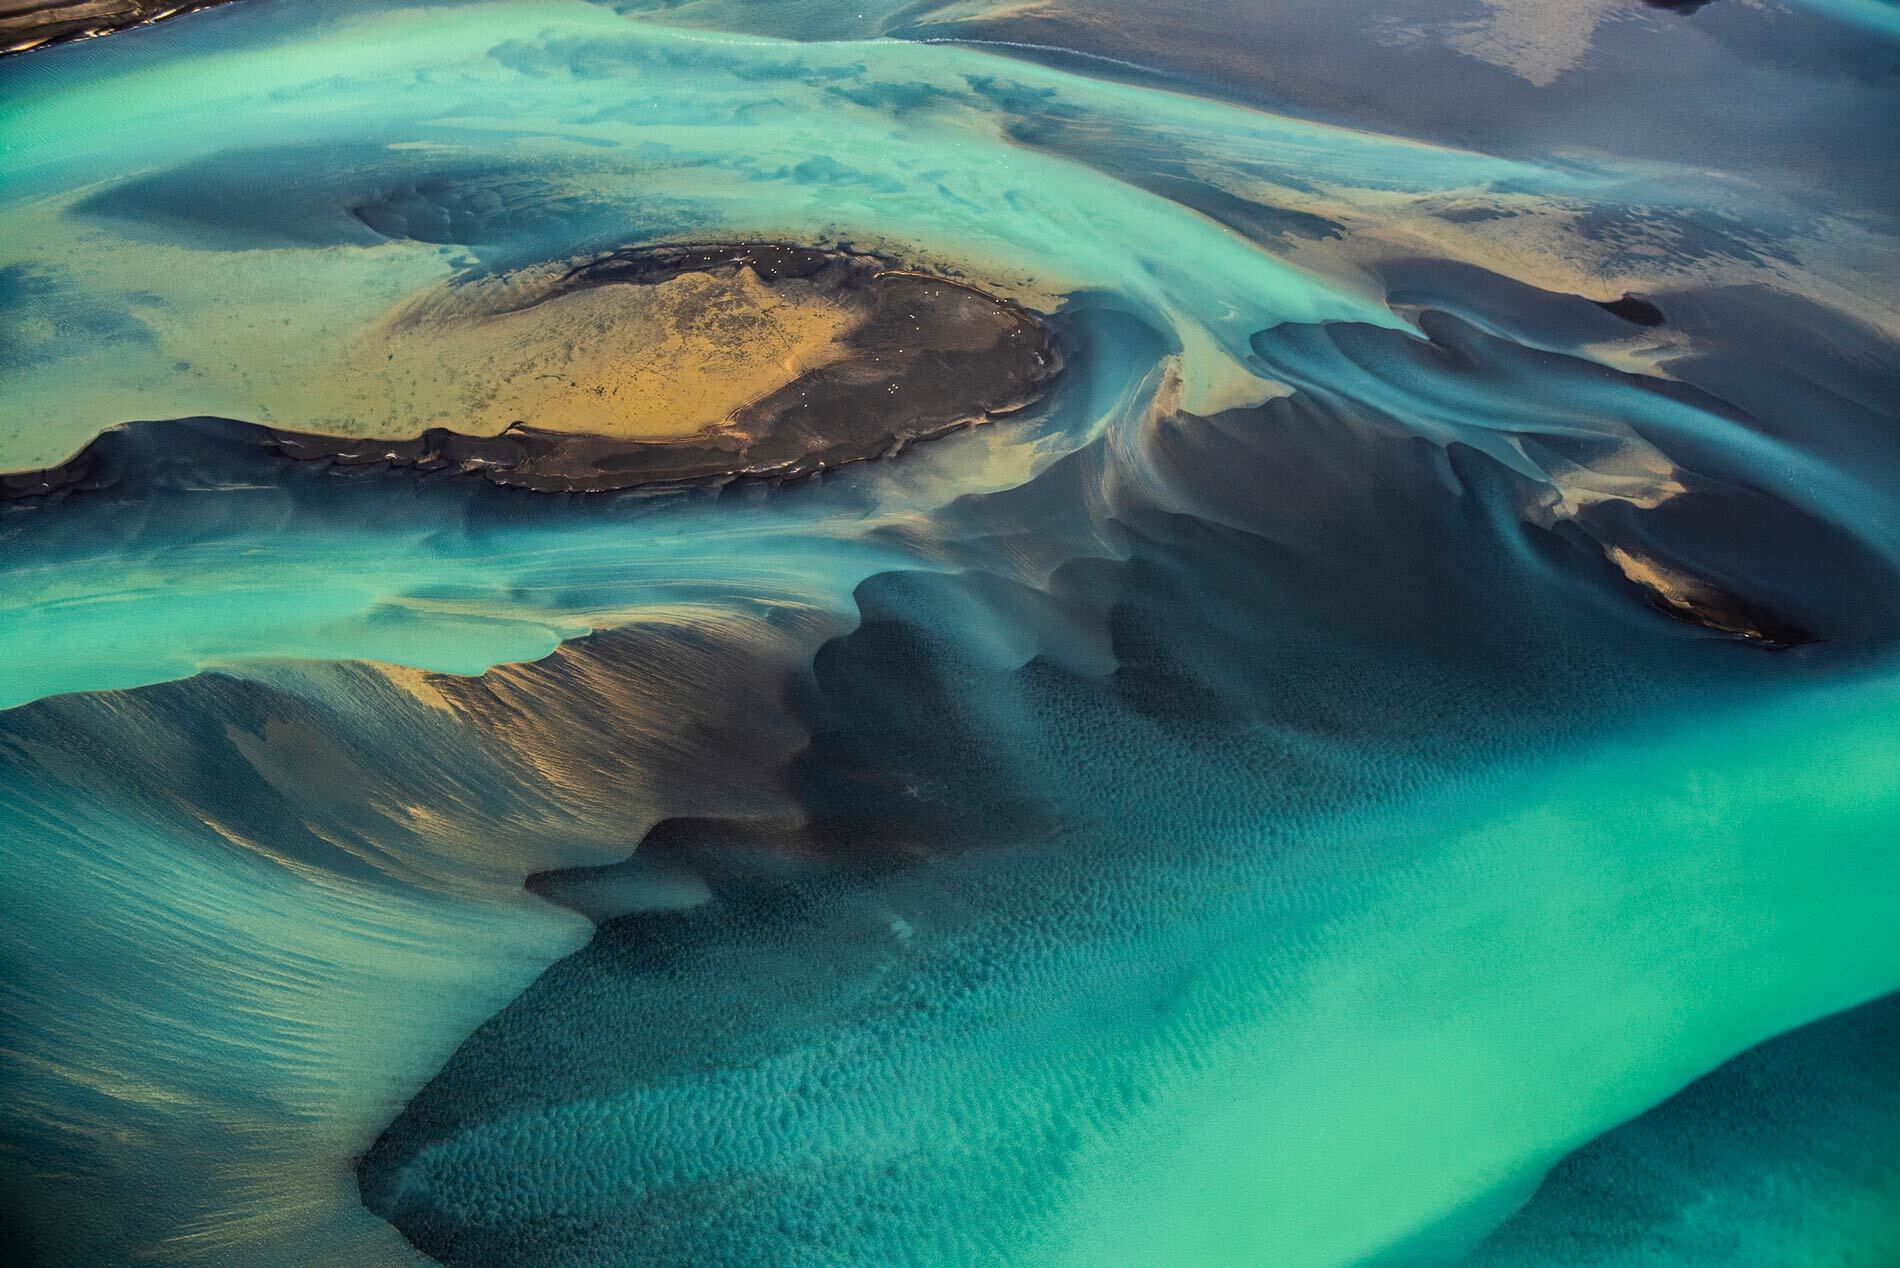

Filename: Scenery.jpg


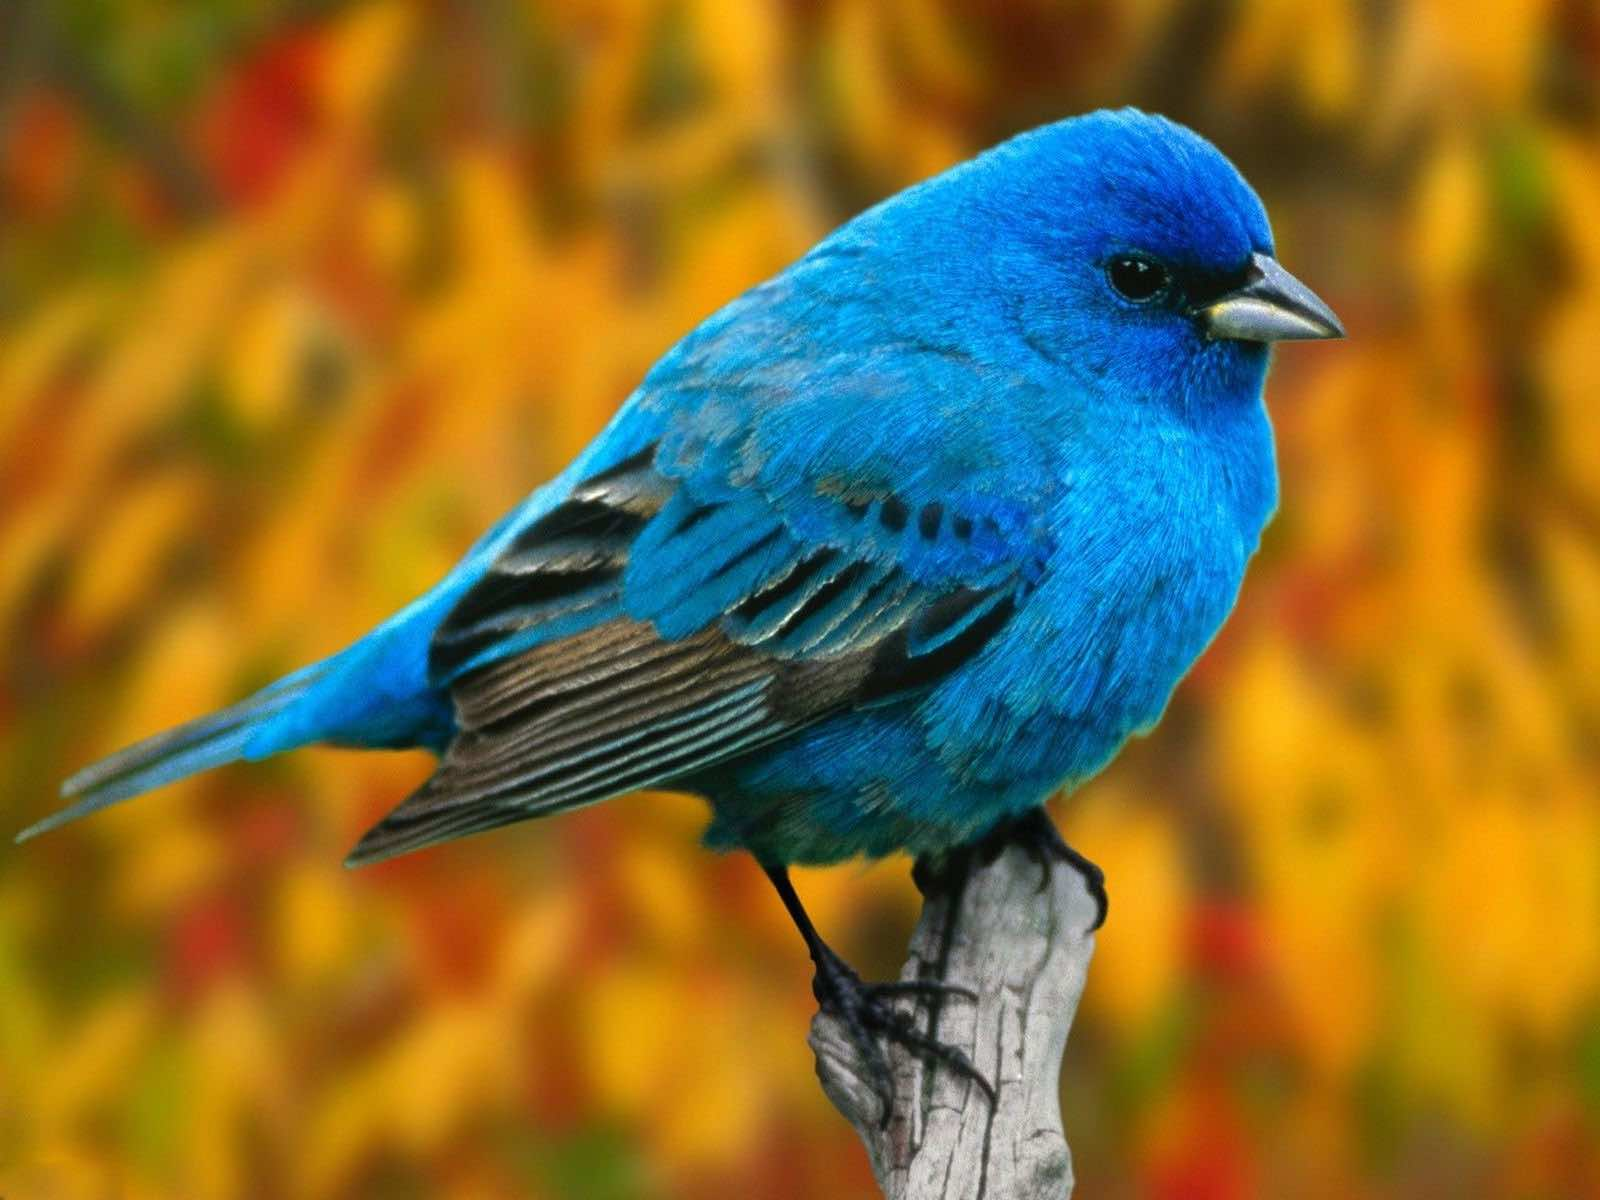

Filename: Parrot.jpg


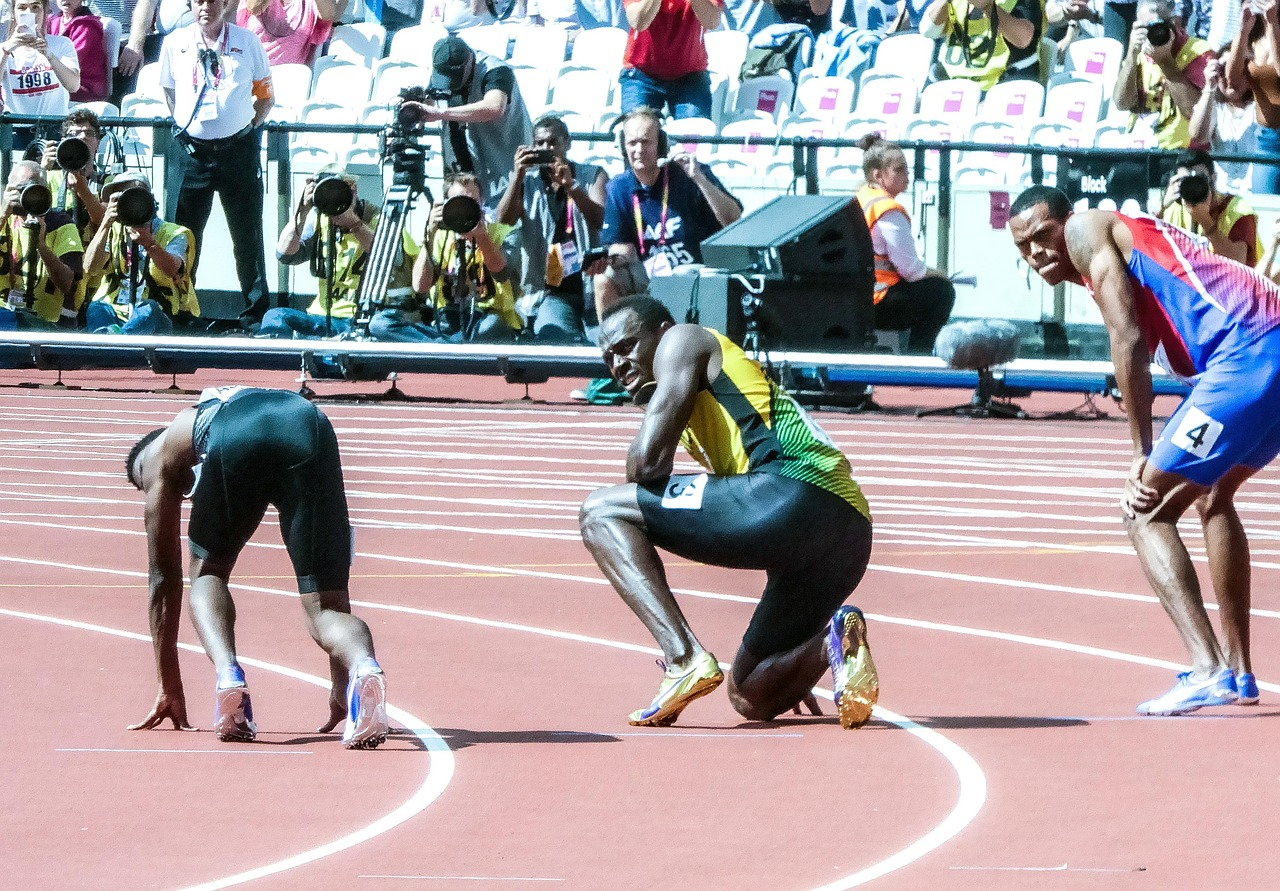

Filename: usain-bolt-3416304_1280.jpg


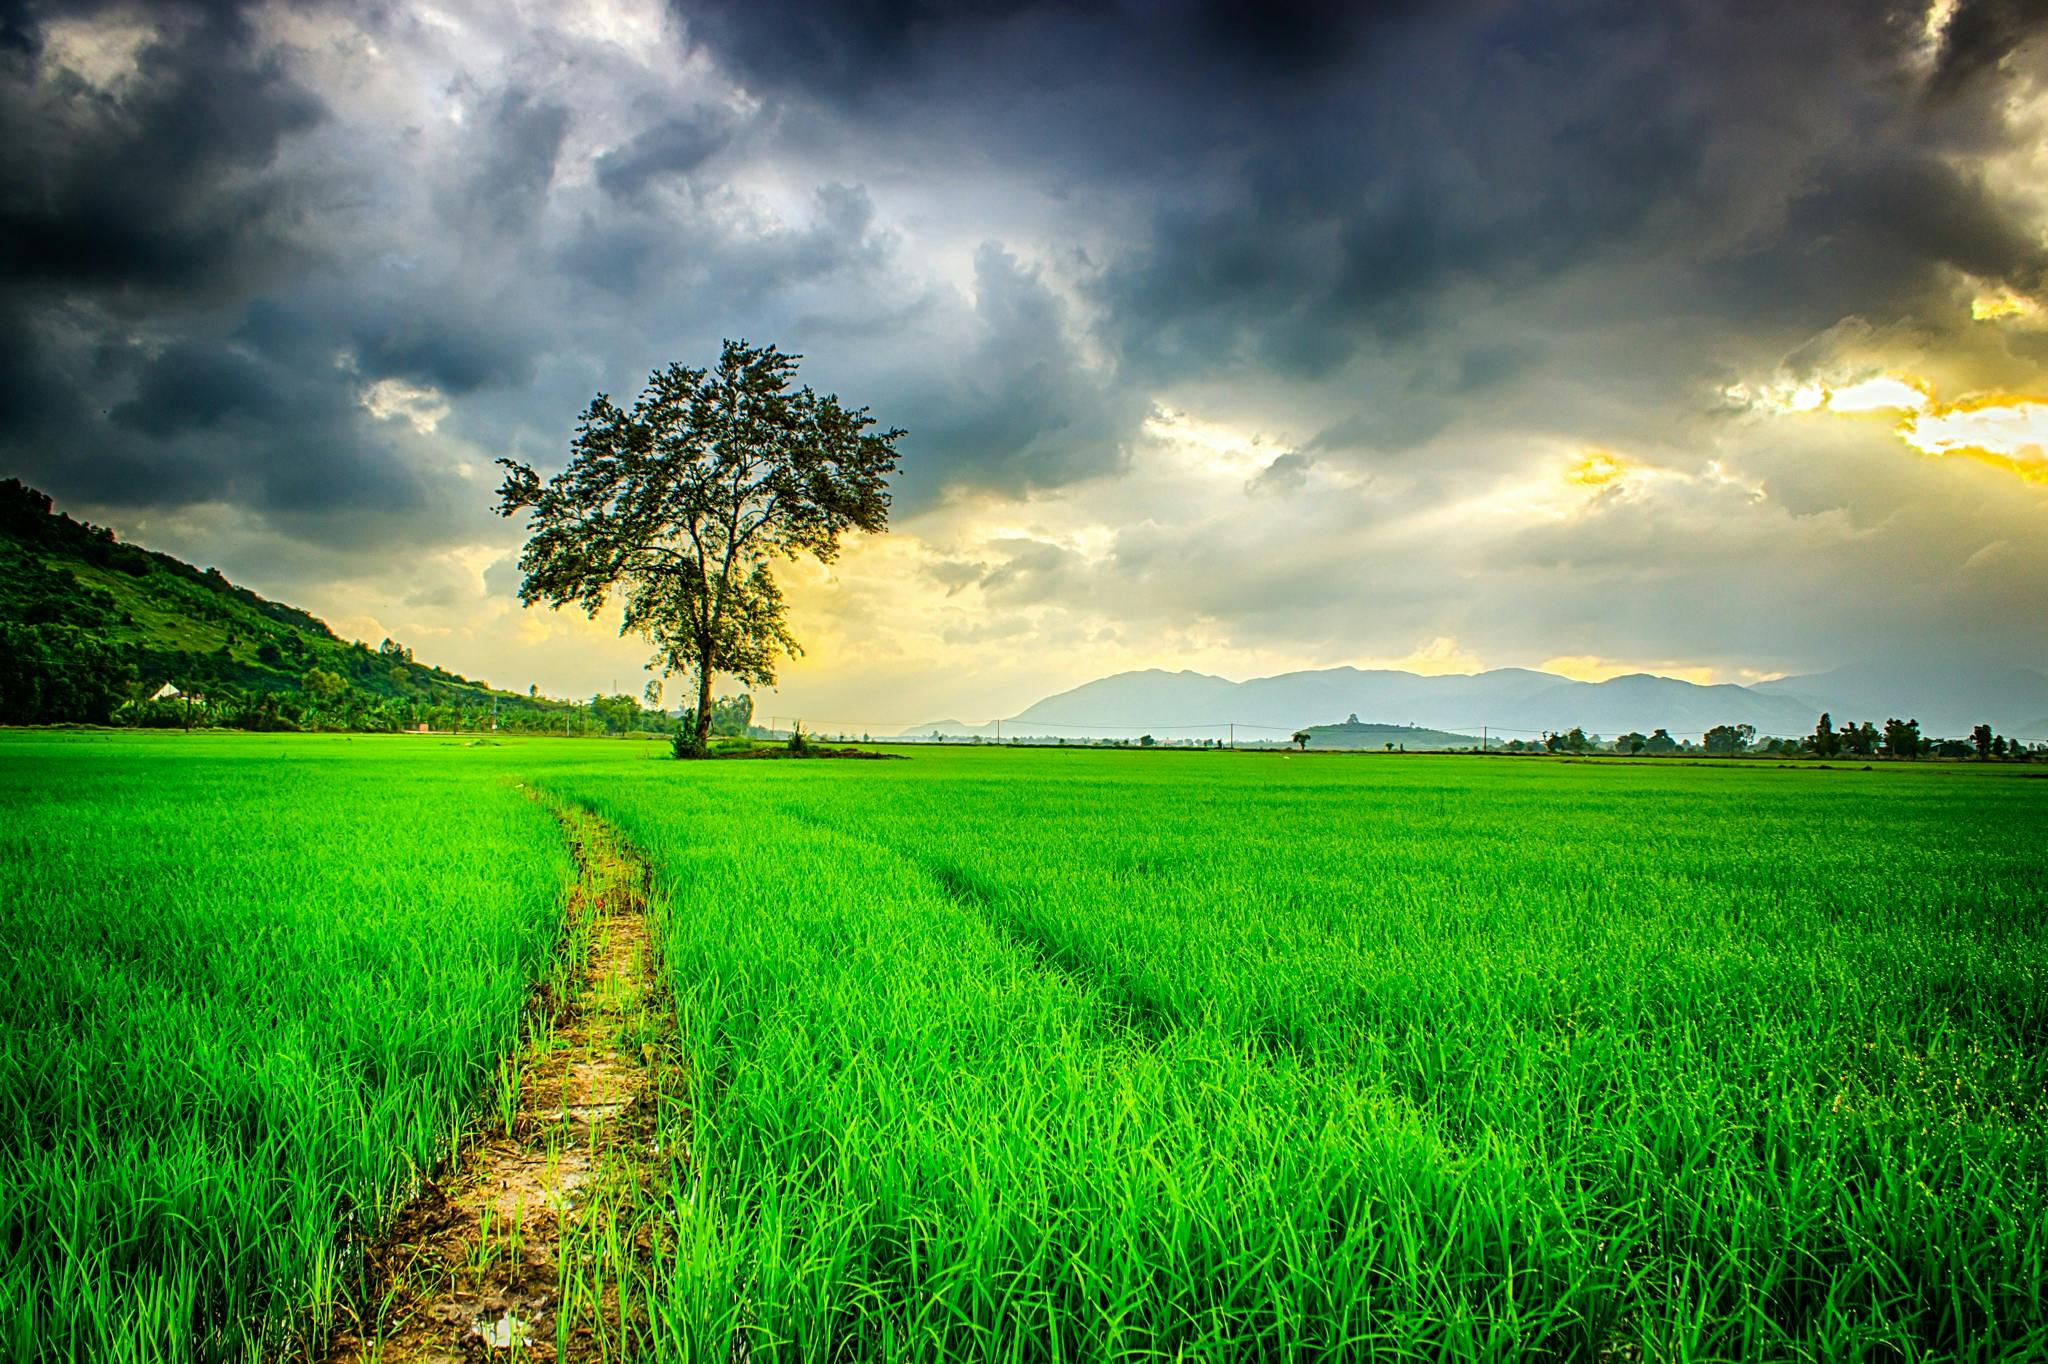

Filename: clouds-cloudy-countryside-236047.jpg


In [21]:
# Upload my own images for testing
from google.colab import files
from IPython.display import Image, display
import os

uploaded = files.upload()

# Display the uploaded images
print("Uploaded images:")
for filename in uploaded.keys():
    display(Image(filename, width=300))
    print(f"Filename: {filename}")

In [22]:
# Generate captions for each uploaded image
print("Generating captions for your images:")
for filename in uploaded.keys():
    print(f"\nImage: {filename}")
    !python sample.py --image=$filename
    print("-" * 50)

Generating captions for your images:

Image: Scenery.jpg
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<start> a close up of a piece of cake with a knife . <end>
--------------------------------------------------

Image: Parrot.jpg
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weig

**3. Investigate what to do if you want to move with Keras**

The process involves several complex steps because PyTorch and Keras have different underlying architectures, weight formats, and layer implementations.

Overview

1. Architectural Differences: PyTorch and Keras (with TensorFlow backend) have different internal representations of models and layers.

2. Weight Format: PyTorch uses .pkl files containing state dictionaries, while Keras uses .h5 files or checkpoint formats.

3. Layer Compatibility: Even layers with the same name (e.g., Linear in PyTorch vs Dense in Keras) may have different parameter ordering or initialization.

Step-by-Step Detailed Plan

Step 1: Analyze the PyTorch Model Architecture

Before any conversion, we must thoroughly understand the model we're working with.

>Purpose: Understand the exact layer structure, parameter names, and weight shapes of the original model.

>Why: You cannot convert weights without knowing what you're converting. This blueprint is essential for rebuilding the same model in Keras.

Here's a brief PyTorch model architecture in code form
```python
# First, let's examine the PyTorch model architecture in detail
from model import EncoderCNN, DecoderRNN

# Recreate the model architecture with the same parameters
embed_size = 256
hidden_size = 512
vocab_size = 10000  # This should match the actual vocab size from vocab.pkl
num_layers = 1

encoder = EncoderCNN(embed_size)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers)

print("=== Encoder Architecture ===")
print(encoder)
print("\n=== Decoder Architecture ===")
print(decoder)

# Check the parameter names and shapes
print("\n=== Encoder Parameters ===")
for name, param in encoder.named_parameters():
    print(f"{name}: {param.shape}")

print("\n=== Decoder Parameters ===")  
for name, param in decoder.named_parameters():
    print(f"{name}: {param.shape}")
```
Step 2: We have to extract and convert weights from PyTorch to NumPy.

PyTorch weights need to be converted to NumPy arrays for Keras.

>Purpose: Convert PyTorch's tensor-based state dictionary into NumPy arrays, a common format understood by both frameworks.

>Why: Keras cannot directly read PyTorch's .pkl files. NumPy acts as a universal intermediary.
```python
import torch
import numpy as np
import pickle

# Load the PyTorch weights
encoder_weights = torch.load('models/encoder-5-3000.pkl', map_location='cpu')
decoder_weights = torch.load('models/decoder-5-3000.pkl', map_location='cpu')

# Convert to NumPy arrays and create a mapping dictionary
weight_mapping = {}

# Process encoder weights (CNN part)
for name, weight in encoder_weights.items():
    weight_mapping[f'encoder/{name}'] = weight.numpy()

# Process decoder weights (LSTM part) - this is more complex
for name, weight in decoder_weights.items():
    weight_mapping[f'decoder/{name}'] = weight.numpy()

print("Available weight arrays:", list(weight_mapping.keys()))
```
Step 3: Rebuild Equivalent Model in Keras

We have to create the same model architecture in Keras.

>Purpose: Create a new model in Keras that mirrors the architecture of the original PyTorch model as closely as possible.

>Why: The weights are designed for a specific architecture. You need an identical "skeleton" in Keras to correctly "wear" the PyTorch weights.
```python
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.layers import GlobalAveragePooling2D

def create_keras_encoder(embed_size):
    # Use ResNet152 as base (same as PyTorch implementation)
    base_model = ResNet152(weights='imagenet', include_top=False)
    
    # Freeze base model layers
    for layer in base_model.layers:
        layer.trainable = False
    
    # Add custom layers to match PyTorch architecture
    inputs = Input(shape=(224, 224, 3))
    x = base_model(inputs)
    x = GlobalAveragePooling2D()(x)
    x = Dense(embed_size, activation='linear')(x)  # Linear transformation
    
    return Model(inputs, x, name='encoder')

def create_keras_decoder(embed_size, hidden_size, vocab_size, num_layers):
    # Inputs: image features and captions
    features_input = Input(shape=(embed_size,))
    caption_input = Input(shape=(None,))
    
    # Embedding layer
    embedding = Embedding(vocab_size, embed_size)
    embedded = embedding(caption_input)
    
    # LSTM layers - need to handle multiple layers if num_layers > 1
    lstm_layer = LSTM(hidden_size, return_sequences=True, return_state=True)
    
    # Initial state from image features
    initial_state = Dense(hidden_size * 2, activation='tanh')(features_input)
    h0 = initial_state[:, :hidden_size]
    c0 = initial_state[:, hidden_size:]
    
    # LSTM processing
    lstm_output, _, _ = lstm_layer(embedded, initial_state=[h0, c0])
    
    # Output layer
    outputs = Dense(vocab_size, activation='softmax')(lstm_output)
    
    return Model([features_input, caption_input], outputs, name='decoder')

# Create Keras models
keras_encoder = create_keras_encoder(embed_size)
keras_decoder = create_keras_decoder(embed_size, hidden_size, vocab_size, num_layers)

print("Keras Encoder Summary:")
keras_encoder.summary()
print("\nKeras Decoder Summary:")
keras_decoder.summary()
```
Step 4: Manually Load Weights into Keras Model

>Purpose: The most critical step. Manually transpose and reshape the NumPy arrays to match Keras's expected weight formats and load them into the new model.

>Why: This is where the main challenge lies. Layers like Linear (PyTorch) and Dense (Keras) have the same function but store their weight matrices with different dimensions (e.g., [output, input] vs. [input, output]).

This is the most complex part - manually mapping PyTorch weights to Keras layers.
```python
def load_pytorch_weights_to_keras(keras_model, weight_mapping, model_type):
    """
    Manually load PyTorch weights into Keras model
    """
    for layer in keras_model.layers:
        if isinstance(layer, Dense):
            # Handle dense layers
            pytorch_w_key = f'{model_type}.linear.weight'
            pytorch_b_key = f'{model_type}.linear.bias'
            
            if pytorch_w_key in weight_mapping:
                # PyTorch weights are [out_features, in_features]
                # Keras expects [in_features, out_features]
                w = weight_mapping[pytorch_w_key].T  # Transpose!
                b = weight_mapping.get(pytorch_b_key, None)
                
                if b is not None:
                    layer.set_weights([w, b])
                else:
                    layer.set_weights([w])
        
        elif isinstance(layer, LSTM):
            # Handle LSTM layers - this is very complex!
            # PyTorch LSTM weights are organized differently than Keras
            for i in range(4):  # 4 gates in LSTM
                w_ih_key = f'{model_type}.lstm.weight_ih_l0'
                w_hh_key = f'{model_type}.lstm.weight_hh_l0'
                b_ih_key = f'{model_type}.lstm.bias_ih_l0'
                b_hh_key = f'{model_type}.lstm.bias_hh_l0'
                
                # This requires careful slicing and concatenation
                # This is simplified - actual implementation needs exact mapping
                pass

# Load weights
load_pytorch_weights_to_keras(keras_encoder, weight_mapping, 'encoder')
load_pytorch_weights_to_keras(keras_decoder, weight_mapping, 'decoder')
```
Step 5: Verify Weight Compatibility and Test

>Purpose: Feed sample data through both models to ensure the outputs are identical or very similar.

>Why: To verify that the conversion was successful and the Keras model behaves the same as the original PyTorch model.
```python
# Test if the models work with the loaded weights
def test_keras_model():
    # Create dummy input
    dummy_image = np.random.rand(1, 224, 224, 3).astype(np.float32)
    dummy_caption = np.array([[1, 2, 3]])  # Example token indices
    
    # Get features from encoder
    features = keras_encoder.predict(dummy_image)
    
    # Get prediction from decoder
    prediction = keras_decoder.predict([features, dummy_caption])
    
    print("Keras model test successful!")
    return prediction

try:
    result = test_keras_model()
    print("Output shape:", result.shape)
except Exception as e:
    print("Error during testing:", e)
```
Step 6: Alternative Approach - ONNX Conversion

For complex models, using ONNX as an intermediate format can be more reliable.

>Purpose: Use the Open Neural Network Exchange (ONNX) format as a intermediary to automate much of the conversion process.

>Why: For very complex models, manual conversion is extremely error-prone. ONNX provides a standardized format and conversion tools to translate a model from PyTorch to Keras (via TensorFlow) more reliably.
```python
# Export PyTorch model to ONNX
dummy_input = torch.randn(1, 3, 224, 224)
torch.onnx.export(encoder, dummy_input, "encoder.onnx")
torch.onnx.export(decoder, (dummy_input, torch.randint(0, 1000, (1, 10))), "decoder.onnx")

# Then use ONNX to TensorFlow conversion tools
# !pip install onnx-tf
# import onnx
# from onnx_tf.backend import prepare
#
# onnx_model = onnx.load("encoder.onnx")
# tf_rep = prepare(onnx_model)
# tf_rep.export_graph("encoder_tf")
```
Key Challenges and Considerations

Weight Transposition: PyTorch and Keras often use different weight orientations (especially for linear/dense layers).

LSTM Complexity: LSTM weight organization differs significantly between frameworks.

Layer Naming: Parameter names won't match, requiring manual mapping.

Batch Normalization: Handling of batch norm layers may differ.

Initialization: Some layers might have different initialization schemes.

Recommendation

For production use, it's often better to:

We should retrain in Keras if possible, rather than converting weights

We should use ONNX as an intermediate format for more reliable conversion

We should also consider framework-specific deployment (keep PyTorch for inference if that's what was used for training)


**4. (Advance assignment) Code reading and rewriting**

After analyzing the PyTorch model architecture in model.py, I would describe and implement it in Keras as follows:

**Step 1: Deep Code Reading of model.py**

Analyzing the PyTorch implementation to understand the exact architecture.
```python
# Examine the model.py file in detail
with open('model.py', 'r') as f:
    model_code = f.read()

print("=== COMPLETE model.py CODE ===")
print(model_code)
```
```python
# Break down the encoder architecture
print("=== ENCODER ARCHITECTURE ANALYSIS ===")
encoder_lines = []
lines = model_code.split('\n')
in_encoder = False
for line in lines:
    if 'class EncoderCNN' in line:
        in_encoder = True
    if in_encoder and 'class DecoderRNN' in line:
        break
    if in_encoder:
        encoder_lines.append(line)

for line in encoder_lines:
    print(line)
```
```python
# Break down the decoder architecture  
print("\n=== DECODER ARCHITECTURE ANALYSIS ===")
decoder_lines = []
in_decoder = False
for line in lines:
    if 'class DecoderRNN' in line:
        in_decoder = True
    if in_decoder and 'def forward' in line:
        break
    if in_decoder:
        decoder_lines.append(line)

for line in decoder_lines:
    print(line)
```
```python
# Check the forward methods to understand data flow
print("\n=== FORWARD METHOD ANALYSIS ===")
forward_lines = []
in_forward = False
for i, line in enumerate(lines):
    if 'def forward' in line:
        in_forward = True
        print(f"\n{line}")
    elif in_forward and line.strip() and not line.startswith(' ') and not line.startswith('def'):
        in_forward = False
    if in_forward:
        print(f"{i+1:3}: {line}")
```
**Step 2: Keras Implementation**
```python
# Install required packages
!pip install tensorflow
```
```python
# Now let's create the Keras equivalent
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Dense, LSTM, Embedding,
                                   GlobalAveragePooling2D, Dropout)
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.optimizers import Adam

class ImageCaptioningKeras:
    """
    Keras implementation of the image captioning model
    Based on the PyTorch architecture from model.py
    """
    
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.num_layers = num_layers
        
        self.encoder = self._build_encoder()
        self.decoder = self._build_decoder()
        
    def _build_encoder(self):
        """Build the CNN encoder similar to PyTorch's EncoderCNN"""
        # Load ResNet152 without top layers (same as PyTorch)
        base_model = ResNet152(weights='imagenet',
                              include_top=False,
                              input_shape=(224, 224, 3))
        
        # Freeze ResNet layers (equivalent to PyTorch's pre-trained CNN)
        for layer in base_model.layers:
            layer.trainable = False
        
        # Build the encoder pipeline
        inputs = Input(shape=(224, 224, 3), name='encoder_input')
        
        # Pass through ResNet
        x = base_model(inputs)
        
        # Global average pooling (similar to adaptive avg pool in PyTorch)
        x = GlobalAveragePooling2D()(x)
        
        # Linear layer to get image features (equivalent to PyTorch's linear layer)
        features = Dense(self.embed_size, activation='linear', name='image_features')(x)
        
        return Model(inputs, features, name='keras_encoder')
    
    def _build_decoder(self):
        """Build the LSTM decoder similar to PyTorch's DecoderRNN"""
        # Two inputs: image features and caption sequences
        image_features_input = Input(shape=(self.embed_size,), name='decoder_image_input')
        caption_input = Input(shape=(None,), name='decoder_caption_input')  # Variable length sequences
        
        # Embedding layer (equivalent to PyTorch's embedding)
        embedding_layer = Embedding(input_dim=self.vocab_size,
                                  output_dim=self.embed_size,
                                  name='word_embedding')
        embedded = embedding_layer(caption_input)
        
        # Prepare initial LSTM state from image features
        # PyTorch uses a linear layer to create [h0, c0] from features
        initial_state_dense = Dense(self.hidden_size * 2, activation='tanh',
                                  name='initial_state_transform')
        initial_state = initial_state_dense(image_features_input)
        
        # Split into hidden state and cell state
        h0 = initial_state[:, :self.hidden_size]
        c0 = initial_state[:, self.hidden_size:]
        
        # LSTM layer (single layer as in original PyTorch code)
        # return_sequences=True to get output at each time step
        # return_state=True to get final states if needed
        lstm_output, state_h, state_c = LSTM(
            self.hidden_size,
            return_sequences=True,
            return_state=True,
            name='lstm_layer'
        )(embedded, initial_state=[h0, c0])
        
        # Output layer (equivalent to PyTorch's linear layer)
        outputs = Dense(self.vocab_size, activation='softmax', name='output_layer')(lstm_output)
        
        return Model(inputs=[image_features_input, caption_input],
                    outputs=outputs,
                    name='keras_decoder')
    
    def compile_models(self, learning_rate=0.001):
        """Compile the models with appropriate optimizers and losses"""
        # Encoder doesn't need compilation as it's used for feature extraction
        # Decoder needs compilation for training
        self.decoder.compile(
            optimizer=Adam(learning_rate=learning_rate),
            loss='sparse_categorical_crossentropy',  # For sequence generation
            metrics=['accuracy']
        )
    
    def summary(self):
        """Print model summaries"""
        print("=" * 50)
        print("ENCODER SUMMARY:")
        print("=" * 50)
        self.encoder.summary()
        
        print("\n" + "=" * 50)
        print("DECODER SUMMARY:")
        print("=" * 50)
        self.decoder.summary()

# Now let's test our Keras implementation
def test_keras_implementation():
    """Test that our Keras model can be created and runs"""
    # Use the same parameters as the PyTorch model
    EMBED_SIZE = 256
    HIDDEN_SIZE = 512
    VOCAB_SIZE = 10000  # Example vocab size
    
    print("Creating Keras model with same parameters as PyTorch...")
    model = ImageCaptioningKeras(EMBED_SIZE, HIDDEN_SIZE, VOCAB_SIZE)
    model.compile_models()
    model.summary()
    
    # Test with dummy data
    print("\nTesting with dummy data...")
    batch_size = 2
    
    # Dummy image input (224x224 RGB)
    dummy_images = tf.random.normal([batch_size, 224, 224, 3])
    
    # Dummy caption input (sequence length 10)
    dummy_captions = tf.random.uniform([batch_size, 10], 0, VOCAB_SIZE, dtype=tf.int32)
    
    # Get features from encoder
    features = model.encoder.predict(dummy_images)
    print(f"Encoder features shape: {features.shape}")
    
    # Get predictions from decoder
    predictions = model.decoder.predict([features, dummy_captions])
    print(f"Decoder predictions shape: {predictions.shape}")
    
    return model

# Run the test
keras_model = test_keras_implementation()
```
**Step 3: Comparison with Machine Translation Example**

Key similarities with machine translation seq2seq:

 1. Both use encoder-decoder architecture
 2. Both handle variable-length sequences
 3. Both use embedding layers for input tokens
 4. Both use RNNs (LSTM) for sequence processing
 5. Both need to handle initial state management

Differences from machine translation:
 1. Image captioning uses CNN encoder instead of RNN encoder
 2. Initial state comes from image features, not encoder RNN states
 3. Different input preprocessing (images vs text)

**Step 4: Key Implementation Notes**

Important implementation details based on PyTorch code analysis:

1. The PyTorch encoder uses:
    - ResNet backbone (frozen)
    - Adaptive average pooling
    - Linear layer to get image features

2. The PyTorch decoder uses:
    - Embedding layer for captions
    - LSTM with initial state from image features
    - Linear output layer

3. Key differences in Keras implementation:
    - Weight initialization will be different
    - Layer names and parameter ordering differ
    - Training loop structure is different

4. To use PyTorch weights, we would need to:
    - Extract weights from .pkl files
    - Transpose matrices where needed (Dense vs Linear)
    - Reformat LSTM weights to Keras format
    - Manually set weights layer by layer



**5. (Advance assignment) Developmental survey**

1. When translating into other languages (e.g., Japanese and English) using the implementation of Problem 1

The Problem 1 implementation is a character-level seq2seq model for translation. Here are the steps and considerations for adapting it to a language pair like Japanese and English:

Key Challenges & Steps:

Tokenization:

Problem: The original model uses character-level tokenization. This works for European languages with small alphabets but is problematic for Japanese, which uses thousands of Kanji characters.

Solution: Switch to subword tokenization (e.g., SentencePiece, WordPiece) or word-level tokenization with a much larger vocabulary. For Japanese, a tool like MeCab (for word segmentation) combined with subword tokenization is essential.

Data Preprocessing:

Cleaning: The text data must be meticulously cleaned and normalized.

Alignment: You need a large, high-quality parallel corpus of Japanese-English sentences (e.g., from OPUS, Tanaka Corpus, or JParaCrawl).

Model Architecture Modifications:

Vocabulary Size: The vocabulary size will explode compared to the original model. The embedding layer and final output layer must be scaled up significantly, requiring more parameters and memory.

Model Capacity: To handle the complexity of translation between two structurally different languages, the model will likely need more layers (a deeper encoder/decoder) and a larger hidden state size.

Training Strategy:

Batching: Use bucketing to group sentences of similar lengths together for efficient training.

Validation: Use a dedicated validation set with metrics like BLEU (Bilingual Evaluation Understudy) to monitor true translation quality, not just loss.

Summary: Adapting the simple character-level model to Japanese-English translation would require a fundamental change in tokenization strategy, a much larger model capacity, and a significant, high-quality dataset.

---
2. What are the advanced methods of machine translation?

The field has evolved far beyond the basic seq2seq model of Problem 1.

Evolutionary Methods:

Transformer Architecture (The Current Standard):

Key Innovation: completely replaces RNNs/ LSTMs with Self-Attention and Multi-Head Attention mechanisms.

Why it's better: It allows the model to weigh the importance of all words in the sentence simultaneously, regardless of distance. This solves the long-range dependency problem of RNNs and is vastly more parallelizable, leading to faster training.

Example: The original "Attention Is All You Need" paper by Vaswani et al. Models like Google's Transformer.

Pre-trained Massively Multilingual Models:

Key Innovation: Instead of training a model from scratch for one language pair, train a single giant model on text from over 100 languages.

Why it's better: The model learns a shared representation across languages, enabling zero-shot and few-shot translation (translating between language pairs it never saw explicitly during training). It also benefits from transfer learning.

Examples: mBART, M2M-100 (Facebook), and mT5 (Google).

Large Language Models (LLMs) for Translation:

Key Innovation: Using general-purpose LLMs like GPT-4 for translation by framing it as a text completion task (e.g., with a prompt like "Translate the following English text to Japanese: ...").

Why it's better: These models have immense world knowledge and reasoning capabilities, allowing them to handle nuanced translations, idioms, and complex context better than dedicated translation models in many cases.

Summary: The evolution moved from RNNs → Transformers → massive multilingual pre-training → using general-purpose LLMs. The focus shifted from dedicated, pair-specific models to general, context-aware polyglots.

---
3. How to generate an image from text? (Text-to-Image Generation)

This is the inverse of image captioning and is a rapidly advancing field.

Key Methods & What They Offer:

Generative Adversarial Networks (GANs):

How it works: A two-part model: a Generator creates images from text descriptions, and a Discriminator tries to distinguish these fake images from real ones. They compete, forcing the generator to produce increasingly realistic images.

What it offers: High-quality, high-resolution images very quickly.

Examples: StackGAN, AttnGAN, DALL-E 1 (used a modified GAN approach).

Autoregressive Models:

How it works: Treats image generation like language modeling. An image is converted into a sequence of tokens (e.g., via VQ-VAE). The model (e.g., a Transformer) then predicts the next token in the image sequence conditioned on the text.

What it offers: Excellent coherence and faithfulness to the text prompt.

Example: Parti (Google).

Diffusion Models (The Current State-of-the-Art):

How it works: A two-step process:

Forward diffusion: Gradually add noise to a real image until it becomes pure noise.

Reverse diffusion: Train a neural network to reverse this process, turning noise back into an image, conditioned on a text prompt.

What it offers: Unparalleled creative diversity, photorealism, and ability to follow complex, compositional text prompts. They generate images of stunning quality and detail.

Examples: DALL-E 2, Stable Diffusion, Midjourney, Imagen.

Summary: The field has evolved from GANs to Autoregressive models to Diffusion Models, which are now the dominant force. They offer a powerful tool for turning imaginative text descriptions into corresponding, high-fidelity images, with applications in art, design, advertising, and prototyping.